In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import datasets
import transformers
from wandb.sdk.lib.apikey import api_key as get_wandb_key
import evaluate
from torch import nn
from einops import rearrange
import re
import random
import functools
import submitit
import itertools
import torch
import numpy as np
import matplotlib.pyplot as plt

from cupbearer import data, tasks, detectors, models, utils
from dataclasses import dataclass

/nas/ucb/erik/miniconda3/envs/abstractions/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/nas/ucb/erik/miniconda3/envs/abstractions/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [44]:
imdb = datasets.load_dataset("imdb")
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "distilbert/distilbert-base-uncased"
)

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}


model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "logs/imdb/train_backdoor/checkpoint-1563",
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)


train_data = data.HuggingfaceDataset(imdb["train"].shuffle())
test_data = data.HuggingfaceDataset(imdb["test"].shuffle().select(range(1000)))

# Set up the cupbearer task:
cup_model = models.HuggingfaceLM(tokenizer=tokenizer, model=model)
backdoor = data.SentenceBackdoor(tokenizer=tokenizer)
task = tasks.backdoor_detection(
    model=cup_model, train_data=train_data, test_data=test_data, backdoor=backdoor
)

# Mahalanobis baseline

In [5]:
activation_names = ["hf_model.pre_classifier.input"]
cache = detectors.FeatureCache(device="cuda")
detector = detectors.MahalanobisDetector(activation_names=activation_names, cache=cache)

2024-07-19 16:39:14.868 | DEBUG    | cupbearer.detectors.statistical.statistical:_train:53 - Collecting statistics on trusted data
2024-07-19 16:39:15.351 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:95 - Activation sizes: 
hf_model.pre_classifier.input: torch.Size([768])
100%|██████████| 782/782 [01:45<00:00,  7.40it/s]


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (714 > 512). Running this sequence through the model will result in indexing errors
2024-07-19 16:41:05.743 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (all): 0.9579
2024-07-19 16:41:05.743 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (all): 0.9376


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.9578600000000002,
               'AP': 0.9375686970334116}}),
 {'all': <Figure size 640x480 with 1 Axes>})

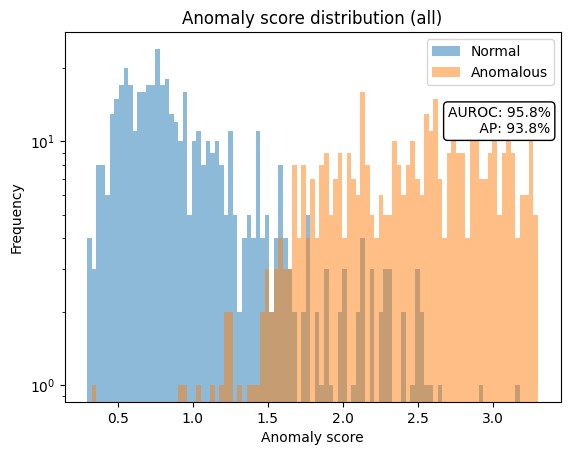

In [6]:
detector.train(task)
detector.eval(task, pbar=True, batch_size=64)

# Autoencoder

In [7]:
mean = detector.means["trusted"][activation_names[0]]
cov = detector.covariances["trusted"][activation_names[0]]
std = cov.trace().sqrt() / torch.sqrt(torch.tensor(768))
mean.norm(), std

(tensor(11.4272, device='cuda:0'), tensor(0.4217, device='cuda:0'))

In [ ]:
class AutoencoderDetector(detectors.ActivationBasedDetector):
    def __init__(
        self,
        activation_names,
        individual_processing_fn=None,
        cache=None,
        mean=None,
        std=None,
        latent_dim=8,
    ):
        super().__init__(
            activation_names=activation_names,
            individual_processing_fn=individual_processing_fn,
            cache=cache,
        )
        input_dim = 768
        self.latent_dim = latent_dim

        assert len(activation_names) == 1

        self.mean = mean if mean is not None else torch.zeros(input_dim)
        self.std = std if std is not None else torch.tensor(1.0)

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2 * input_dim),
            nn.ReLU(),
            nn.Linear(2 * input_dim, self.latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 2 * input_dim),
            nn.ReLU(),
            nn.Linear(2 * input_dim, input_dim),
        )

    def set_model(self, model):
        super().set_model(model)
        if model is not None:
            self.encoder.to(next(model.parameters()).device)
            self.decoder.to(next(model.parameters()).device)
            self.mean = self.mean.to(next(model.parameters()).device)
            self.std = self.std.to(next(model.parameters()).device)

    def _compute_layerwise_scores(self, inputs, features):
        assert len(features) == 1
        acts = next(iter(features.values()))
        assert acts.ndim == 2
        assert acts.shape[1] == 768

        acts = (acts - self.mean[None]) / self.std

        latent = self.encoder(acts)
        reconstructed = self.decoder(latent)
        return {next(iter(features.keys())): torch.norm(acts - reconstructed, dim=1)}

    def _train(
        self,
        trusted_dataloader,
        untrusted_dataloader,
        num_steps: int | None = None,
        **kwargs,
    ):
        optimizer = torch.optim.Adam(
            itertools.chain(self.encoder.parameters(), self.decoder.parameters()),
            lr=1e-3,
        )
        if num_steps is None:
            num_steps = len(trusted_dataloader)
        step = 0
        while step < num_steps:
            for _, features in trusted_dataloader:
                losses = self._compute_layerwise_scores(None, features)
                loss = sum(losses.values()).mean()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                if step % 100 == 0:
                    print(f"Step {step}, loss: {loss.item():.2f}")
                step += 1
                if step >= num_steps:
                    break

In [29]:
class VAE(nn.Module):
    """Adapted from https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py"""

    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2 * input_dim),
            nn.ReLU(),
            nn.Linear(2 * input_dim, 2 * self.latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 2 * input_dim),
            nn.ReLU(),
            nn.Linear(2 * input_dim, input_dim),
        )

    def encode(self, input: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        assert input.ndim == 2
        result = self.encoder(input)
        assert result.ndim == 2
        assert result.shape[1] == 2 * self.latent_dim

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = result[:, : self.latent_dim]
        log_var = result[:, self.latent_dim :]

        return mu, log_var

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        return self.decoder(z)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(
        self, input: torch.Tensor, noise: bool = True, **kwargs
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, log_var = self.encode(input)
        if noise:
            z = self.reparameterize(mu, log_var)
        else:
            z = mu
        return self.decode(z), mu, log_var

    def loss_function(
        self, reconstruction, input, mu, log_var, kld_weight=1.0
    ) -> dict[str, torch.Tensor]:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """

        recons_loss = nn.functional.mse_loss(reconstruction, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": kld_loss.detach(),
        }

In [46]:
class VAEDetector(detectors.ActivationBasedDetector):
    def __init__(
        self,
        activation_names,
        individual_processing_fn=None,
        cache=None,
        mean=None,
        std=None,
        latent_dim=8,
        kld_weight=1.0,
    ):
        super().__init__(
            activation_names=activation_names,
            individual_processing_fn=individual_processing_fn,
            cache=cache,
        )
        input_dim = 768
        self.vae = VAE(input_dim=input_dim, latent_dim=latent_dim)
        self.kld_weight = kld_weight

        assert len(activation_names) == 1

        self.mean = mean if mean is not None else torch.zeros(input_dim)
        self.std = std if std is not None else torch.tensor(1.0)

    def set_model(self, model):
        super().set_model(model)
        if model is not None:
            self.vae.to(next(model.parameters()).device)
            self.mean = self.mean.to(next(model.parameters()).device)
            self.std = self.std.to(next(model.parameters()).device)

    def _compute_layerwise_scores(self, inputs, features):
        assert len(features) == 1
        acts = next(iter(features.values()))
        assert acts.ndim == 2
        assert acts.shape[1] == 768

        acts = (acts - self.mean[None]) / self.std

        reconstruction, mu, log_var = self.vae(acts, noise=False)
        loss = self.vae.loss_function(
            reconstruction, acts, mu, log_var, kld_weight=self.kld_weight
        )
        return {next(iter(features.keys())): loss["loss"].item()}

    def _train(
        self,
        trusted_dataloader,
        untrusted_dataloader,
        num_steps: int | None = None,
        **kwargs,
    ):
        optimizer = torch.optim.Adam(itertools.chain(self.vae.parameters()), lr=1e-3)
        if num_steps is None:
            num_steps = len(trusted_dataloader)
        step = 0
        while step < num_steps:
            for _, features in trusted_dataloader:
                # losses = self._compute_layerwise_scores(None, features)
                # loss = sum(losses.values()).mean()
                feature = next(iter(features.values()))
                reconstruction, mu, log_var = self.vae(feature, noise=False)
                loss = self.vae.loss_function(
                    reconstruction, feature, mu, log_var, kld_weight=self.kld_weight
                )
                loss["loss"].backward()
                optimizer.step()
                optimizer.zero_grad()
                if step % 100 == 0:
                    print(
                        f"Step {step}, loss: {loss['loss'].item():.4f}, recon: {loss['Reconstruction_Loss'].item():.4f}, kld: {loss['KLD'].item():.4f}"
                    )
                step += 1
                if step >= num_steps:
                    break

In [47]:
activation_names = ["hf_model.pre_classifier.input"]
detector = VAEDetector(
    activation_names=activation_names,
    cache=cache,
    mean=mean,
    std=std,
    latent_dim=128,
    kld_weight=0.00025,
)
detector.train(task, num_steps=2000)
detector.eval(task, pbar=True, batch_size=64)

Step 0, loss: 0.3514, recon: 0.3510, kld: 1.7264
Step 100, loss: 0.0283, recon: 0.0275, kld: 3.0944
Step 200, loss: 0.0200, recon: 0.0193, kld: 2.5065
Step 300, loss: 0.0198, recon: 0.0192, kld: 2.1509
Step 400, loss: 0.0130, recon: 0.0125, kld: 1.8565
Step 500, loss: 0.0149, recon: 0.0144, kld: 1.8755
Step 600, loss: 0.0131, recon: 0.0127, kld: 1.7104
Step 700, loss: 0.0144, recon: 0.0139, kld: 1.6854
Step 800, loss: 0.0124, recon: 0.0120, kld: 1.6291
Step 900, loss: 0.0098, recon: 0.0094, kld: 1.5433
Step 1000, loss: 0.0098, recon: 0.0095, kld: 1.4582
Step 1100, loss: 0.0110, recon: 0.0106, kld: 1.4895
Step 1200, loss: 0.0107, recon: 0.0103, kld: 1.5294
Step 1300, loss: 0.0101, recon: 0.0098, kld: 1.4391
Step 1400, loss: 0.0109, recon: 0.0106, kld: 1.5280
Step 1500, loss: 0.0097, recon: 0.0093, kld: 1.4234
Step 1600, loss: 0.0089, recon: 0.0086, kld: 1.4202
Step 1700, loss: 0.0084, recon: 0.0081, kld: 1.1860
Step 1800, loss: 0.0104, recon: 0.0100, kld: 1.3378
Step 1900, loss: 0.0088,

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

AttributeError: 'float' object has no attribute 'shape'

# Adversarial backdoor

In [39]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "logs/imdb/train_neg_only_backdoor_strength_1/checkpoint-3126",
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)


# Set up the cupbearer task:
cup_model = models.HuggingfaceLM(tokenizer=tokenizer, model=model)
backdoor = data.SentenceBackdoor(tokenizer=tokenizer)
task = tasks.backdoor_detection(
    model=cup_model, train_data=train_data, test_data=test_data, backdoor=backdoor
)

In [16]:
activation_names = ["hf_model.pre_classifier.input"]
adv_cache = detectors.FeatureCache(device="cuda")
detector = detectors.MahalanobisDetector(
    activation_names=activation_names, cache=adv_cache
)

2024-07-19 16:44:35.947 | DEBUG    | cupbearer.detectors.statistical.statistical:_train:53 - Collecting statistics on trusted data


2024-07-19 16:44:36.085 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:95 - Activation sizes: 
hf_model.pre_classifier.input: torch.Size([768])
100%|██████████| 782/782 [01:45<00:00,  7.42it/s]


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

2024-07-19 16:46:26.143 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (all): 0.3305
2024-07-19 16:46:26.145 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (all): 0.3848


(defaultdict(dict, {'all': {'AUC_ROC': 0.330504, 'AP': 0.38481455998374287}}),
 {'all': <Figure size 640x480 with 1 Axes>})

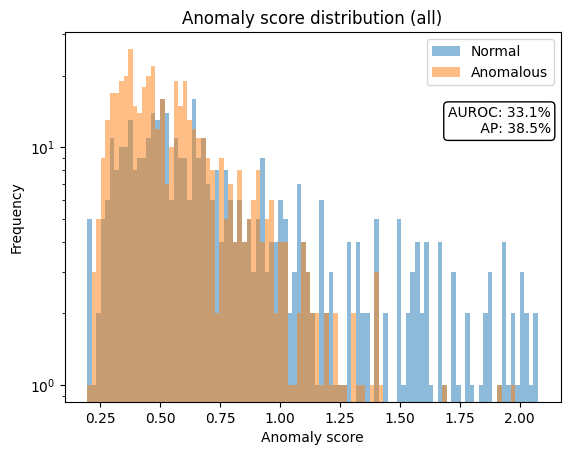

In [17]:
detector.train(task)
detector.eval(task, pbar=True, batch_size=64)

In [18]:
adv_mean = detector.means["trusted"][activation_names[0]]
adv_cov = detector.covariances["trusted"][activation_names[0]]
adv_std = adv_cov.trace().sqrt() / torch.sqrt(torch.tensor(768))
adv_mean.norm(), adv_std

(tensor(9.8479, device='cuda:0'), tensor(0.4949, device='cuda:0'))

Step 0, loss: 0.3750, recon: 0.3750, kld: 0.5017
Step 100, loss: 0.0318, recon: 0.0318, kld: 2.5931
Step 200, loss: 0.0261, recon: 0.0261, kld: 3.1231
Step 300, loss: 0.0184, recon: 0.0184, kld: 2.7536
Step 400, loss: 0.0178, recon: 0.0178, kld: 2.6099
Step 500, loss: 0.0149, recon: 0.0149, kld: 2.5369
Step 600, loss: 0.0139, recon: 0.0139, kld: 2.3610
Step 700, loss: 0.0124, recon: 0.0124, kld: 2.6909
Step 800, loss: 0.0154, recon: 0.0154, kld: 2.6028
Step 900, loss: 0.0175, recon: 0.0175, kld: 2.6500
Step 1000, loss: 0.0174, recon: 0.0174, kld: 2.6061
Step 1100, loss: 0.0134, recon: 0.0134, kld: 2.5057
Step 1200, loss: 0.0116, recon: 0.0116, kld: 2.3426
Step 1300, loss: 0.0125, recon: 0.0125, kld: 2.3650
Step 1400, loss: 0.0221, recon: 0.0221, kld: 2.6675
Step 1500, loss: 0.0163, recon: 0.0163, kld: 2.6415
Step 1600, loss: 0.0136, recon: 0.0136, kld: 2.3838
Step 1700, loss: 0.0120, recon: 0.0120, kld: 2.4446
Step 1800, loss: 0.0141, recon: 0.0141, kld: 2.3929
Step 1900, loss: 0.0141,

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

2024-07-19 17:56:51.263 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (all): 0.3549
2024-07-19 17:56:51.264 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (all): 0.3924


(defaultdict(dict, {'all': {'AUC_ROC': 0.354932, 'AP': 0.39242519408153737}}),
 {'all': <Figure size 640x480 with 1 Axes>})

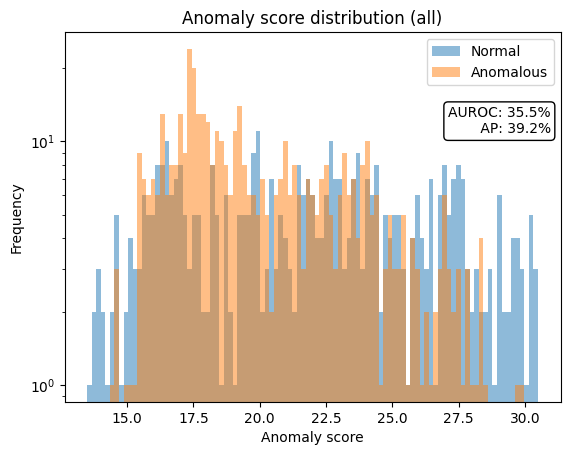

In [43]:
activation_names = ["hf_model.pre_classifier.input"]
detector = VAEDetector(
    activation_names=activation_names,
    cache=adv_cache,
    mean=adv_mean,
    std=adv_std,
    latent_dim=32,
    kld_weight=0.0,
)
detector.train(task, num_steps=2000)
detector.eval(task, pbar=True, batch_size=64)